# Comet MLfrom comet_ml import Experiment

In [1]:
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="HeNPARP7EmQTxxVRpewzuqm8b",
#     project_name="face-normal-liveness",
#     workspace="ahmadirfaan",
# )

In [2]:
# hyper_params = {
#     "input_size": 224,
#     "num_classes": 2,
#     "batch_size": 32,
#     "learning_rate": 2e-4
# }

In [3]:
# experiment.log_parameters(hyper_params)

# Import Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

import PIL

import os

# device = torch.device('cuda:0')
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

# Dataset and Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [7]:
class BoneAgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = str(self.df.iloc[index].id_x)+".jpg"
        label = torch.from_numpy(np.asarray([self.df.iloc[index].boneage]))
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image.float(), label.float()

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

In [9]:
bs = 64

data_train = BoneAgeDataset("boneage-training-dataset-segmented-1.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)
data_val = BoneAgeDataset("boneage-validation-1.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
# val_size = int(len(data_train) * 0.2)
# train_size = len(data_train) - (val_size)

# train_set, val_set = random_split(
#     data_train,
#     [train_size, val_size]
# )

trainloader = DataLoader(data_train, batch_size=bs)
valloader = DataLoader(data_val, batch_size=bs)

In [10]:
len(data_train), len(data_val)

(9794, 2457)

# Architecture and Config

In [11]:
import torch
from torch import nn
import timm

class BoneAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(BoneAgeModel, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.n_features = self.backbone.head.in_features
        self.backbone.reset_classifier(0)
        self.fc = nn.Linear(self.n_features, 1)
        
    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = True # Unfreezing Weight

    def forward(self, images):
        features = self.backbone(images)              # features = (bs, embedding_size)
        output = self.fc(features)                    # outputs  = (bs, num_classes)
        return output
    
model = BoneAgeModel()
model.to(device)
model.unfreeze()

# Training

In [12]:
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error

In [13]:
# criterion = nn.MSELoss()
def criterion(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs.view(-1), targets.view(-1)))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, eta_min=1e-6)
# callback = Callback(model, early_stop_patience=4, outdir="model")

In [14]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:         
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss = loss / 1
            
        scaler.scale(loss).backward()
    
        if (step + 1) % 1 == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [15]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [16]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        TARGETS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    val_rmse = mean_squared_error(TARGETS, PREDS, squared=False)
    gc.collect()
    
    val_error = np.abs(PREDS - TARGETS).sum().data    
    val_mae = np.mean(np.abs(TARGETS - PREDS))
    
    val_smape = np.mean(2.0 * np.abs(TARGETS - PREDS) / ((np.abs(TARGETS) + np.abs(PREDS)) +1e-10 ))
    
    return epoch_loss, val_rmse, val_mae, val_smape

In [17]:
import time
import copy
from collections import defaultdict
import gc
from torch.cuda import amp
from tqdm import tqdm

In [18]:
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [19]:
!mkdir Model-1

mkdir: cannot create directory ‘Model-1’: File exists


In [20]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=trainloader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse, val_epoch_mae, val_epoch_smape = valid_one_epoch(model, valloader, 
                                                         device=device, 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        history['Valid MAE'].append(val_epoch_mae)
        history['Valid SMAPE'].append(val_epoch_smape)
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        print(f'Valid MAE: {val_epoch_mae}')
        print(f'Valid SMAPE: {val_epoch_smape}')
        
        if val_epoch_rmse <= best_epoch_rmse:
            print(f"{c_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Model-1/RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save(model.state_dict(), PATH)
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [21]:
model, history = run_training(model, optimizer, scheduler,
                              device=device,
                              num_epochs=100)

[INFO] Using GPU: A100-SXM4-40GB



  0%|          | 0/154 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 39/39 [00:06<00:00,  5.58it/s, Epoch=1, LR=5.67e-5, Valid_Loss=27.2]


Valid RMSE: 27.27815818786621
Valid MAE: 21.43388557434082
Valid SMAPE: 0.190028578042984
Validation Loss Improved (inf ---> 27.27815818786621)



100%|██████████| 39/39 [00:06<00:00,  5.84it/s, Epoch=2, LR=2.56e-6, Valid_Loss=23]  


Valid RMSE: 23.207210540771484
Valid MAE: 17.827404022216797
Valid SMAPE: 0.16005389392375946
Validation Loss Improved (27.27815818786621 ---> 23.207210540771484)



100%|██████████| 39/39 [00:06<00:00,  5.81it/s, Epoch=3, LR=3.23e-5, Valid_Loss=21.4]


Valid RMSE: 21.60318946838379
Valid MAE: 16.11356544494629
Valid SMAPE: 0.1476137489080429
Validation Loss Improved (23.207210540771484 ---> 21.60318946838379)



100%|██████████| 39/39 [00:09<00:00,  4.33it/s, Epoch=4, LR=9.39e-5, Valid_Loss=21.6]


Valid RMSE: 21.714773178100586
Valid MAE: 16.08162498474121
Valid SMAPE: 0.14704377949237823



100%|██████████| 39/39 [00:07<00:00,  5.37it/s, Epoch=5, LR=7.96e-5, Valid_Loss=19.8]


Valid RMSE: 19.959049224853516
Valid MAE: 14.924227714538574
Valid SMAPE: 0.13776659965515137
Validation Loss Improved (21.60318946838379 ---> 19.959049224853516)



100%|██████████| 39/39 [00:06<00:00,  5.88it/s, Epoch=6, LR=1.44e-5, Valid_Loss=19]  


Valid RMSE: 19.135391235351562
Valid MAE: 14.447660446166992
Valid SMAPE: 0.13258077204227448
Validation Loss Improved (19.959049224853516 ---> 19.135391235351562)



100%|██████████| 39/39 [00:06<00:00,  5.69it/s, Epoch=7, LR=1.24e-5, Valid_Loss=18.7]


Valid RMSE: 18.85466957092285
Valid MAE: 14.20628833770752
Valid SMAPE: 0.1299794316291809
Validation Loss Improved (19.135391235351562 ---> 18.85466957092285)



100%|██████████| 39/39 [00:06<00:00,  5.66it/s, Epoch=8, LR=7.7e-5, Valid_Loss=18.8]


Valid RMSE: 18.943246841430664
Valid MAE: 14.226123809814453
Valid SMAPE: 0.13051725924015045



100%|██████████| 39/39 [00:07<00:00,  4.98it/s, Epoch=9, LR=9.53e-5, Valid_Loss=19.3]


Valid RMSE: 19.430438995361328
Valid MAE: 14.569259643554688
Valid SMAPE: 0.1343388557434082



100%|██████████| 39/39 [00:07<00:00,  5.54it/s, Epoch=10, LR=3.52e-5, Valid_Loss=17.6]


Valid RMSE: 17.687129974365234
Valid MAE: 13.551851272583008
Valid SMAPE: 0.12417516857385635
Validation Loss Improved (18.85466957092285 ---> 17.687129974365234)



100%|██████████| 39/39 [00:06<00:00,  5.75it/s, Epoch=11, LR=1.88e-6, Valid_Loss=17.5]


Valid RMSE: 17.60306739807129
Valid MAE: 13.345623970031738
Valid SMAPE: 0.12193509191274643
Validation Loss Improved (17.687129974365234 ---> 17.60306739807129)



100%|██████████| 39/39 [00:07<00:00,  5.55it/s, Epoch=12, LR=5.36e-5, Valid_Loss=18.6]


Valid RMSE: 18.703432083129883
Valid MAE: 14.169048309326172
Valid SMAPE: 0.1286429762840271



100%|██████████| 39/39 [00:06<00:00,  5.75it/s, Epoch=13, LR=9.99e-5, Valid_Loss=17.9]


Valid RMSE: 18.048067092895508
Valid MAE: 13.825555801391602
Valid SMAPE: 0.12822747230529785



100%|██████████| 39/39 [00:07<00:00,  5.55it/s, Epoch=14, LR=5.98e-5, Valid_Loss=19.7]


Valid RMSE: 19.936342239379883
Valid MAE: 14.397582054138184
Valid SMAPE: 0.13534015417099



100%|██████████| 39/39 [00:06<00:00,  5.85it/s, Epoch=15, LR=3.42e-6, Valid_Loss=17.1]


Valid RMSE: 17.25324058532715
Valid MAE: 13.039935111999512
Valid SMAPE: 0.12098687887191772
Validation Loss Improved (17.60306739807129 ---> 17.25324058532715)



100%|██████████| 39/39 [00:07<00:00,  5.27it/s, Epoch=16, LR=2.94e-5, Valid_Loss=17.9]


Valid RMSE: 18.016244888305664
Valid MAE: 13.48056697845459
Valid SMAPE: 0.12386613339185715



100%|██████████| 39/39 [00:07<00:00,  4.89it/s, Epoch=17, LR=9.23e-5, Valid_Loss=17.8]


Valid RMSE: 17.948518753051758
Valid MAE: 13.379009246826172
Valid SMAPE: 0.12337115406990051



100%|██████████| 39/39 [00:08<00:00,  4.54it/s, Epoch=18, LR=8.21e-5, Valid_Loss=17.3]


Valid RMSE: 17.447254180908203
Valid MAE: 13.057537078857422
Valid SMAPE: 0.1210407242178917



100%|██████████| 39/39 [00:06<00:00,  5.80it/s, Epoch=19, LR=1.66e-5, Valid_Loss=15.9]


Valid RMSE: 16.020235061645508
Valid MAE: 12.209869384765625
Valid SMAPE: 0.11203847825527191
Validation Loss Improved (17.25324058532715 ---> 16.020235061645508)



100%|██████████| 39/39 [00:06<00:00,  5.67it/s, Epoch=20, LR=1.05e-5, Valid_Loss=16.9]


Valid RMSE: 17.026578903198242
Valid MAE: 12.737634658813477
Valid SMAPE: 0.11811502277851105



100%|██████████| 39/39 [00:08<00:00,  4.55it/s, Epoch=21, LR=7.43e-5, Valid_Loss=19.5]


Valid RMSE: 19.6656494140625
Valid MAE: 15.059568405151367
Valid SMAPE: 0.1338679939508438



100%|██████████| 39/39 [00:06<00:00,  5.73it/s, Epoch=22, LR=9.65e-5, Valid_Loss=19.5]


Valid RMSE: 19.681974411010742
Valid MAE: 14.417163848876953
Valid SMAPE: 0.12906205654144287



100%|██████████| 39/39 [00:07<00:00,  5.46it/s, Epoch=23, LR=3.82e-5, Valid_Loss=16.4]


Valid RMSE: 16.54648780822754
Valid MAE: 12.567371368408203
Valid SMAPE: 0.11479770392179489



100%|██████████| 39/39 [00:07<00:00,  5.27it/s, Epoch=24, LR=1.39e-6, Valid_Loss=17]  


Valid RMSE: 17.152816772460938
Valid MAE: 12.79306411743164
Valid SMAPE: 0.11652771383523941



100%|██████████| 39/39 [00:07<00:00,  5.39it/s, Epoch=25, LR=5.05e-5, Valid_Loss=17.8]


Valid RMSE: 17.922508239746094
Valid MAE: 13.166987419128418
Valid SMAPE: 0.12053956836462021



100%|██████████| 39/39 [00:06<00:00,  5.60it/s, Epoch=26, LR=9.96e-5, Valid_Loss=18.6]


Valid RMSE: 18.69870376586914
Valid MAE: 13.980497360229492
Valid SMAPE: 0.13467200100421906



100%|██████████| 39/39 [00:08<00:00,  4.72it/s, Epoch=27, LR=6.28e-5, Valid_Loss=16.6]


Valid RMSE: 16.7542667388916
Valid MAE: 12.551966667175293
Valid SMAPE: 0.11548062413930893



100%|██████████| 39/39 [00:06<00:00,  5.76it/s, Epoch=28, LR=4.48e-6, Valid_Loss=16.9]


Valid RMSE: 17.02284812927246
Valid MAE: 12.64440631866455
Valid SMAPE: 0.11747042834758759



100%|██████████| 39/39 [00:06<00:00,  5.63it/s, Epoch=29, LR=2.67e-5, Valid_Loss=16.9]


Valid RMSE: 17.014907836914062
Valid MAE: 12.580349922180176
Valid SMAPE: 0.11574594676494598



100%|██████████| 39/39 [00:06<00:00,  5.77it/s, Epoch=30, LR=9.05e-5, Valid_Loss=18.7]


Valid RMSE: 18.80728530883789
Valid MAE: 14.526691436767578
Valid SMAPE: 0.12955719232559204



100%|██████████| 39/39 [00:07<00:00,  4.96it/s, Epoch=31, LR=8.44e-5, Valid_Loss=18.7]


Valid RMSE: 18.866527557373047
Valid MAE: 13.95733642578125
Valid SMAPE: 0.12703366577625275



100%|██████████| 39/39 [00:08<00:00,  4.87it/s, Epoch=32, LR=1.89e-5, Valid_Loss=17.4]


Valid RMSE: 17.54560089111328
Valid MAE: 12.945595741271973
Valid SMAPE: 0.11970636248588562



100%|██████████| 39/39 [00:06<00:00,  5.76it/s, Epoch=33, LR=8.71e-6, Valid_Loss=17.1]


Valid RMSE: 17.266639709472656
Valid MAE: 12.86913013458252
Valid SMAPE: 0.11853569000959396



100%|██████████| 39/39 [00:07<00:00,  5.24it/s, Epoch=34, LR=7.16e-5, Valid_Loss=17.2]


Valid RMSE: 17.316864013671875
Valid MAE: 12.898773193359375
Valid SMAPE: 0.1192096620798111



100%|██████████| 39/39 [00:06<00:00,  5.67it/s, Epoch=35, LR=9.76e-5, Valid_Loss=17]  


Valid RMSE: 17.170677185058594
Valid MAE: 12.78964614868164
Valid SMAPE: 0.11796198040246964



100%|██████████| 39/39 [00:07<00:00,  4.99it/s, Epoch=36, LR=4.12e-5, Valid_Loss=15.8]


Valid RMSE: 15.935449600219727
Valid MAE: 12.004433631896973
Valid SMAPE: 0.11019327491521835
Validation Loss Improved (16.020235061645508 ---> 15.935449600219727)



100%|██████████| 39/39 [00:07<00:00,  4.92it/s, Epoch=37, LR=1.1e-6, Valid_Loss=16.5]


Valid RMSE: 16.62798500061035
Valid MAE: 12.35606861114502
Valid SMAPE: 0.11256441473960876



100%|██████████| 39/39 [00:07<00:00,  5.27it/s, Epoch=38, LR=4.74e-5, Valid_Loss=18.2]


Valid RMSE: 18.345699310302734
Valid MAE: 13.373598098754883
Valid SMAPE: 0.12160670012235641



100%|██████████| 39/39 [00:07<00:00,  5.31it/s, Epoch=39, LR=9.91e-5, Valid_Loss=17.3]


Valid RMSE: 17.402273178100586
Valid MAE: 13.331706047058105
Valid SMAPE: 0.1266568899154663



100%|██████████| 39/39 [00:07<00:00,  5.29it/s, Epoch=40, LR=6.58e-5, Valid_Loss=16.6]


Valid RMSE: 16.69425392150879
Valid MAE: 12.671385765075684
Valid SMAPE: 0.11662891507148743



100%|██████████| 39/39 [00:07<00:00,  4.98it/s, Epoch=41, LR=5.71e-6, Valid_Loss=16.6]


Valid RMSE: 16.65043067932129
Valid MAE: 12.473710060119629
Valid SMAPE: 0.11516749858856201



100%|██████████| 39/39 [00:07<00:00,  4.94it/s, Epoch=42, LR=2.4e-5, Valid_Loss=16.3]


Valid RMSE: 16.435958862304688
Valid MAE: 12.270508766174316
Valid SMAPE: 0.11289599537849426



100%|██████████| 39/39 [00:07<00:00,  5.22it/s, Epoch=43, LR=8.86e-5, Valid_Loss=17.8]


Valid RMSE: 18.008255004882812
Valid MAE: 13.61417293548584
Valid SMAPE: 0.12536409497261047



100%|██████████| 39/39 [00:07<00:00,  4.98it/s, Epoch=44, LR=8.66e-5, Valid_Loss=17.8]


Valid RMSE: 17.982887268066406
Valid MAE: 13.339784622192383
Valid SMAPE: 0.1206393763422966



100%|██████████| 39/39 [00:06<00:00,  5.84it/s, Epoch=45, LR=2.14e-5, Valid_Loss=16.2]


Valid RMSE: 16.30708122253418
Valid MAE: 12.324808120727539
Valid SMAPE: 0.1127905324101448



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=46, LR=7.12e-6, Valid_Loss=17.2]


Valid RMSE: 17.314218521118164
Valid MAE: 12.780021667480469
Valid SMAPE: 0.11848846822977066



100%|██████████| 39/39 [00:07<00:00,  4.99it/s, Epoch=47, LR=6.87e-5, Valid_Loss=18.3]


Valid RMSE: 18.477771759033203
Valid MAE: 13.835280418395996
Valid SMAPE: 0.1256701946258545



100%|██████████| 39/39 [00:07<00:00,  5.38it/s, Epoch=48, LR=9.84e-5, Valid_Loss=16.6]


Valid RMSE: 16.69081687927246
Valid MAE: 12.600432395935059
Valid SMAPE: 0.11362770199775696



100%|██████████| 39/39 [00:06<00:00,  5.67it/s, Epoch=49, LR=4.43e-5, Valid_Loss=16.1]


Valid RMSE: 16.28778648376465
Valid MAE: 12.191193580627441
Valid SMAPE: 0.11193867772817612



100%|██████████| 39/39 [00:07<00:00,  4.89it/s, Epoch=50, LR=1e-6, Valid_Loss=17.2]


Valid RMSE: 17.41818618774414
Valid MAE: 12.740803718566895
Valid SMAPE: 0.11687156558036804



100%|██████████| 39/39 [00:07<00:00,  5.46it/s, Epoch=51, LR=4.43e-5, Valid_Loss=16.6]


Valid RMSE: 16.79018211364746
Valid MAE: 12.542847633361816
Valid SMAPE: 0.11535732448101044



100%|██████████| 39/39 [00:06<00:00,  5.74it/s, Epoch=52, LR=9.84e-5, Valid_Loss=16.8]


Valid RMSE: 16.85386848449707
Valid MAE: 12.674484252929688
Valid SMAPE: 0.11780330538749695



100%|██████████| 39/39 [00:07<00:00,  5.14it/s, Epoch=53, LR=6.87e-5, Valid_Loss=16.5]


Valid RMSE: 16.545181274414062
Valid MAE: 12.539424896240234
Valid SMAPE: 0.11594026535749435



100%|██████████| 39/39 [00:07<00:00,  5.28it/s, Epoch=54, LR=7.12e-6, Valid_Loss=15.9]


Valid RMSE: 16.093507766723633
Valid MAE: 12.0846529006958
Valid SMAPE: 0.10997454822063446



100%|██████████| 39/39 [00:07<00:00,  4.96it/s, Epoch=55, LR=2.14e-5, Valid_Loss=15.6]


Valid RMSE: 15.676478385925293
Valid MAE: 11.900644302368164
Valid SMAPE: 0.1091952696442604
Validation Loss Improved (15.935449600219727 ---> 15.676478385925293)



100%|██████████| 39/39 [00:07<00:00,  4.94it/s, Epoch=56, LR=8.66e-5, Valid_Loss=16.6]


Valid RMSE: 16.72441291809082
Valid MAE: 12.744856834411621
Valid SMAPE: 0.11818303912878036



100%|██████████| 39/39 [00:06<00:00,  5.69it/s, Epoch=57, LR=8.86e-5, Valid_Loss=16.7]


Valid RMSE: 16.77011489868164
Valid MAE: 12.703470230102539
Valid SMAPE: 0.11704302579164505



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=58, LR=2.4e-5, Valid_Loss=15.9]


Valid RMSE: 16.043498992919922
Valid MAE: 11.838525772094727
Valid SMAPE: 0.10877582430839539



100%|██████████| 39/39 [00:07<00:00,  5.18it/s, Epoch=59, LR=5.71e-6, Valid_Loss=15.9]


Valid RMSE: 16.076641082763672
Valid MAE: 11.992602348327637
Valid SMAPE: 0.11026205867528915



100%|██████████| 39/39 [00:07<00:00,  4.99it/s, Epoch=60, LR=6.58e-5, Valid_Loss=15.6]


Valid RMSE: 15.793021202087402
Valid MAE: 11.806415557861328
Valid SMAPE: 0.10854341089725494



100%|██████████| 39/39 [00:09<00:00,  3.91it/s, Epoch=61, LR=9.91e-5, Valid_Loss=16.2]


Valid RMSE: 16.376270294189453
Valid MAE: 12.318424224853516
Valid SMAPE: 0.1140403151512146



100%|██████████| 39/39 [00:07<00:00,  5.52it/s, Epoch=62, LR=4.74e-5, Valid_Loss=15.4]


Valid RMSE: 15.472813606262207
Valid MAE: 11.751180648803711
Valid SMAPE: 0.10846494883298874
Validation Loss Improved (15.676478385925293 ---> 15.472813606262207)



100%|██████████| 39/39 [00:07<00:00,  5.38it/s, Epoch=63, LR=1.1e-6, Valid_Loss=15.6]


Valid RMSE: 15.714739799499512
Valid MAE: 11.787518501281738
Valid SMAPE: 0.10769598931074142



100%|██████████| 39/39 [00:07<00:00,  5.48it/s, Epoch=64, LR=4.12e-5, Valid_Loss=16.7]


Valid RMSE: 16.94174575805664
Valid MAE: 12.565576553344727
Valid SMAPE: 0.11446070671081543



100%|██████████| 39/39 [00:07<00:00,  5.17it/s, Epoch=65, LR=9.76e-5, Valid_Loss=17.2]


Valid RMSE: 17.31623649597168
Valid MAE: 13.052617073059082
Valid SMAPE: 0.11653465777635574



100%|██████████| 39/39 [00:07<00:00,  4.91it/s, Epoch=66, LR=7.16e-5, Valid_Loss=15.6]


Valid RMSE: 15.732464790344238
Valid MAE: 11.902674674987793
Valid SMAPE: 0.10877617448568344



100%|██████████| 39/39 [00:07<00:00,  5.39it/s, Epoch=67, LR=8.71e-6, Valid_Loss=16.4]


Valid RMSE: 16.489599227905273
Valid MAE: 12.125636100769043
Valid SMAPE: 0.11135604977607727



100%|██████████| 39/39 [00:07<00:00,  4.93it/s, Epoch=68, LR=1.89e-5, Valid_Loss=15.9]


Valid RMSE: 16.071592330932617
Valid MAE: 12.161690711975098
Valid SMAPE: 0.11137986928224564



100%|██████████| 39/39 [00:07<00:00,  4.97it/s, Epoch=69, LR=8.44e-5, Valid_Loss=17.5]


Valid RMSE: 17.677387237548828
Valid MAE: 13.136672973632812
Valid SMAPE: 0.11869142204523087



100%|██████████| 39/39 [00:07<00:00,  5.18it/s, Epoch=70, LR=9.05e-5, Valid_Loss=17.1]


Valid RMSE: 17.173463821411133
Valid MAE: 12.855542182922363
Valid SMAPE: 0.1172642633318901



100%|██████████| 39/39 [00:07<00:00,  5.50it/s, Epoch=71, LR=2.67e-5, Valid_Loss=15.7]


Valid RMSE: 15.838895797729492
Valid MAE: 11.903132438659668
Valid SMAPE: 0.10945335030555725



100%|██████████| 39/39 [00:07<00:00,  5.01it/s, Epoch=72, LR=4.48e-6, Valid_Loss=16.1]


Valid RMSE: 16.281177520751953
Valid MAE: 12.070976257324219
Valid SMAPE: 0.11040233820676804



100%|██████████| 39/39 [00:07<00:00,  4.97it/s, Epoch=73, LR=6.28e-5, Valid_Loss=17]  


Valid RMSE: 17.17288589477539
Valid MAE: 12.720610618591309
Valid SMAPE: 0.1162235289812088



100%|██████████| 39/39 [00:06<00:00,  5.88it/s, Epoch=74, LR=9.96e-5, Valid_Loss=17.2]


Valid RMSE: 17.37055778503418
Valid MAE: 12.831714630126953
Valid SMAPE: 0.11694523692131042



100%|██████████| 39/39 [00:07<00:00,  5.39it/s, Epoch=75, LR=5.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.68612289428711
Valid MAE: 11.908492088317871
Valid SMAPE: 0.10954836755990982



100%|██████████| 39/39 [00:08<00:00,  4.84it/s, Epoch=76, LR=1.39e-6, Valid_Loss=15.9]


Valid RMSE: 16.017364501953125
Valid MAE: 12.061532020568848
Valid SMAPE: 0.11118041723966599



100%|██████████| 39/39 [00:07<00:00,  5.50it/s, Epoch=77, LR=3.82e-5, Valid_Loss=16.1]


Valid RMSE: 16.235300064086914
Valid MAE: 12.179499626159668
Valid SMAPE: 0.11097849905490875



100%|██████████| 39/39 [00:07<00:00,  5.44it/s, Epoch=78, LR=9.65e-5, Valid_Loss=15.9]


Valid RMSE: 15.98861026763916
Valid MAE: 12.152100563049316
Valid SMAPE: 0.1109970360994339



100%|██████████| 39/39 [00:07<00:00,  4.95it/s, Epoch=79, LR=7.43e-5, Valid_Loss=16]  


Valid RMSE: 16.101285934448242
Valid MAE: 12.132706642150879
Valid SMAPE: 0.11207094043493271



100%|██████████| 39/39 [00:07<00:00,  5.05it/s, Epoch=80, LR=1.05e-5, Valid_Loss=15.9]


Valid RMSE: 15.979934692382812
Valid MAE: 12.150062561035156
Valid SMAPE: 0.1129983440041542



100%|██████████| 39/39 [00:07<00:00,  4.98it/s, Epoch=81, LR=1.66e-5, Valid_Loss=16.3]


Valid RMSE: 16.487348556518555
Valid MAE: 12.244282722473145
Valid SMAPE: 0.11154672503471375



100%|██████████| 39/39 [00:06<00:00,  5.79it/s, Epoch=82, LR=8.21e-5, Valid_Loss=17.2]


Valid RMSE: 17.36731719970703
Valid MAE: 12.737780570983887
Valid SMAPE: 0.11729195713996887



100%|██████████| 39/39 [00:07<00:00,  4.95it/s, Epoch=83, LR=9.23e-5, Valid_Loss=16.7]


Valid RMSE: 16.785308837890625
Valid MAE: 12.783585548400879
Valid SMAPE: 0.11559908092021942



100%|██████████| 39/39 [00:07<00:00,  4.99it/s, Epoch=84, LR=2.94e-5, Valid_Loss=14.8]


Valid RMSE: 14.856237411499023
Valid MAE: 11.20684814453125
Valid SMAPE: 0.10337965935468674
Validation Loss Improved (15.472813606262207 ---> 14.856237411499023)



100%|██████████| 39/39 [00:07<00:00,  4.93it/s, Epoch=85, LR=3.42e-6, Valid_Loss=15.6]


Valid RMSE: 15.672124862670898
Valid MAE: 11.851076126098633
Valid SMAPE: 0.10851972550153732



100%|██████████| 39/39 [00:07<00:00,  5.25it/s, Epoch=86, LR=5.98e-5, Valid_Loss=16.3]


Valid RMSE: 16.501075744628906
Valid MAE: 12.228326797485352
Valid SMAPE: 0.11385717242956161



100%|██████████| 39/39 [00:07<00:00,  5.41it/s, Epoch=87, LR=9.99e-5, Valid_Loss=15.7]


Valid RMSE: 15.846810340881348
Valid MAE: 11.955816268920898
Valid SMAPE: 0.1097300723195076



100%|██████████| 39/39 [00:07<00:00,  5.45it/s, Epoch=88, LR=5.36e-5, Valid_Loss=15]  


Valid RMSE: 15.118204116821289
Valid MAE: 11.404304504394531
Valid SMAPE: 0.1049090102314949



100%|██████████| 39/39 [00:06<00:00,  5.88it/s, Epoch=89, LR=1.88e-6, Valid_Loss=16.5]


Valid RMSE: 16.65625
Valid MAE: 12.201363563537598
Valid SMAPE: 0.11166977882385254



100%|██████████| 39/39 [00:08<00:00,  4.87it/s, Epoch=90, LR=3.52e-5, Valid_Loss=15.6]


Valid RMSE: 15.703161239624023
Valid MAE: 11.763811111450195
Valid SMAPE: 0.10777437686920166



100%|██████████| 39/39 [00:07<00:00,  5.00it/s, Epoch=91, LR=9.53e-5, Valid_Loss=17.5]


Valid RMSE: 17.646530151367188
Valid MAE: 13.463456153869629
Valid SMAPE: 0.12191443145275116



100%|██████████| 39/39 [00:07<00:00,  4.88it/s, Epoch=92, LR=7.7e-5, Valid_Loss=15.3]


Valid RMSE: 15.364128112792969
Valid MAE: 11.718124389648438
Valid SMAPE: 0.10839866101741791



100%|██████████| 39/39 [00:06<00:00,  5.84it/s, Epoch=93, LR=1.24e-5, Valid_Loss=15.4]


Valid RMSE: 15.529228210449219
Valid MAE: 11.671462059020996
Valid SMAPE: 0.10796856135129929



100%|██████████| 39/39 [00:06<00:00,  5.90it/s, Epoch=94, LR=1.44e-5, Valid_Loss=16.3]


Valid RMSE: 16.400184631347656
Valid MAE: 12.139320373535156
Valid SMAPE: 0.1116599291563034



100%|██████████| 39/39 [00:07<00:00,  4.93it/s, Epoch=95, LR=7.96e-5, Valid_Loss=16.3]


Valid RMSE: 16.437339782714844
Valid MAE: 12.309637069702148
Valid SMAPE: 0.11242859810590744



100%|██████████| 39/39 [00:08<00:00,  4.85it/s, Epoch=96, LR=9.39e-5, Valid_Loss=16.1]


Valid RMSE: 16.228431701660156
Valid MAE: 12.233748435974121
Valid SMAPE: 0.11128740757703781



100%|██████████| 39/39 [00:07<00:00,  5.23it/s, Epoch=97, LR=3.23e-5, Valid_Loss=16]  


Valid RMSE: 16.171655654907227
Valid MAE: 12.225385665893555
Valid SMAPE: 0.11257675290107727



100%|██████████| 39/39 [00:07<00:00,  4.91it/s, Epoch=98, LR=2.56e-6, Valid_Loss=15]  


Valid RMSE: 15.087265014648438
Valid MAE: 11.42465591430664
Valid SMAPE: 0.10547468811273575



100%|██████████| 39/39 [00:06<00:00,  5.74it/s, Epoch=99, LR=5.67e-5, Valid_Loss=15.2]


Valid RMSE: 15.362874984741211
Valid MAE: 11.722868919372559
Valid SMAPE: 0.10758021473884583



100%|██████████| 39/39 [00:07<00:00,  5.37it/s, Epoch=100, LR=0.0001, Valid_Loss=17.3]

Valid RMSE: 17.3902587890625
Valid MAE: 13.415973663330078
Valid SMAPE: 0.12066905200481415

Training complete in 1h 29m 38s
Best RMSE: 14.8562


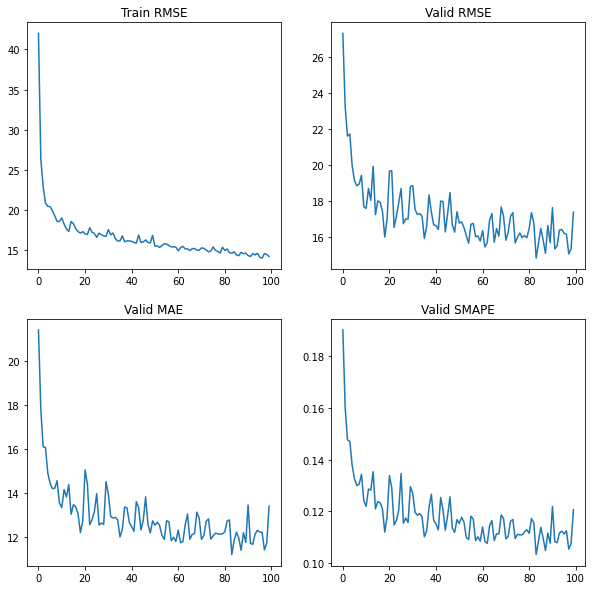

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history['Train Loss'])
axs[0, 0].title.set_text('Train RMSE')
axs[0, 1].plot(history['Valid RMSE'])
axs[0, 1].title.set_text('Valid RMSE')
axs[1, 0].plot(history['Valid MAE'])
axs[1, 0].title.set_text('Valid MAE')
axs[1, 1].plot(history['Valid SMAPE'])
axs[1, 1].title.set_text('Valid SMAPE')